In [1]:
# MODIFY! 
model_name = 'poi-wo'

# Import Libraries & Data 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/d-wo-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [4]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [5]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [6]:
# MODIFY!
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor()
model

PoissonRegressor()

In [7]:
alphas = np.linspace(0.1,1,10)

In [8]:
p_grid = {
    'alpha':alphas,
}

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [11]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.8s finished


GridSearchCV(cv=10, estimator=PoissonRegressor(),
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
             scoring='neg_mean_squared_error', verbose=1)

In [12]:
grid_model.best_params_

{'alpha': 0.30000000000000004}

In [13]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [14]:
hp

alpha    0.3
Name: poi-wo HP, dtype: float64

In [15]:
hp.to_csv(f'./hyperparameters/{model_name}.csv')

# Score Model

In [16]:
# MODIFY! 
from sklearn.linear_model import PoissonRegressor

score_model = PoissonRegressor()
score_model

PoissonRegressor()

In [17]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [18]:
scores = pd.DataFrame(scores)

In [19]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.058475,0.001928,-3.284614,-17.180481,-4.144934
1,0.018607,0.001564,-3.266524,-18.724811,-4.327217
2,0.017402,0.001897,-3.184718,-16.075230,-4.009393
3,0.017405,0.001950,-3.128216,-20.718012,-4.551704
4,0.021961,0.004870,-3.181433,-17.417092,-4.173379
5,0.026974,0.002006,-3.412631,-19.829912,-4.453079
6,0.017492,0.001611,-3.285248,-17.500758,-4.183391
7,0.016507,0.001646,-3.348082,-19.615562,-4.428946
8,0.016991,0.001661,-3.423026,-20.929374,-4.574863
9,0.017789,0.001603,-3.431496,-20.869959,-4.568365


In [20]:
mean_scores = scores.mean()

In [21]:
mean_scores

fit_time                             0.022960
score_time                           0.002074
test_neg_mean_absolute_error        -3.294599
test_neg_mean_squared_error        -18.886119
test_neg_root_mean_squared_error    -4.341527
dtype: float64

# Export Model Score

In [22]:
mean_scores = mean_scores.rename(f'{model_name}')

In [23]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [24]:
# mean_scores

In [25]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [26]:
mean_scores

Fit Time       0.022960
Score Time     0.002074
MAE            3.294599
MSE           18.886119
RMSE           4.341527
Name: poi-wo, dtype: float64

In [27]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [28]:
mean_scores

Fit Time       0.022960
Score Time     0.002074
MAE            3.294599
MSE           18.886119
RMSE           4.341527
STD FT         0.012880
STD ST         0.000997
STD MAE        0.108303
STD MSE        1.757611
STD RMSE       0.203472
Name: poi-wo, dtype: float64

In [29]:
mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [30]:
score_model.fit(X_train,y_train)

PoissonRegressor()

In [31]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

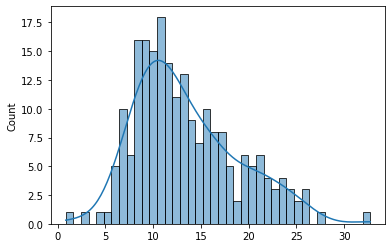

In [32]:
sns.histplot(y_holdout,bins=40,kde=True)

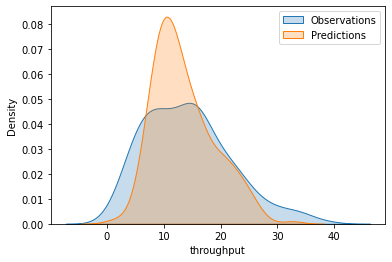

In [33]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

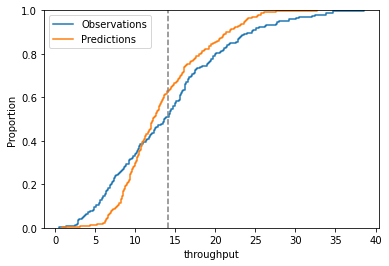

In [34]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [36]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,poi-wo
MAE,3.922977
MSE,26.002281
RMSE,5.099243


In [37]:
err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [38]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.665534
std      5.067424
min    -11.201375
25%     -2.868128
50%     -0.373300
75%      3.369143
max     18.918613
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

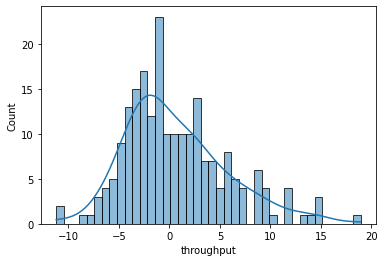

In [39]:
sns.histplot(data=res, kde=True,bins=40)

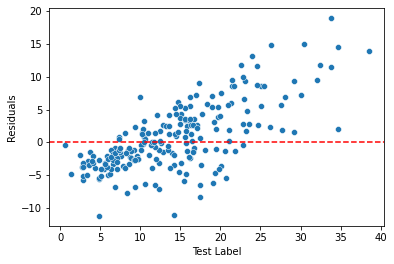

In [40]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

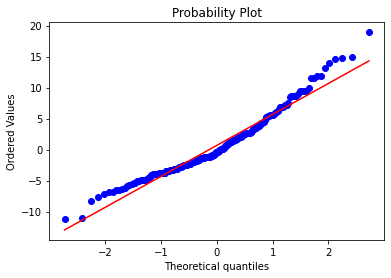

In [41]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [43]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

PoissonRegressor()

In [44]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

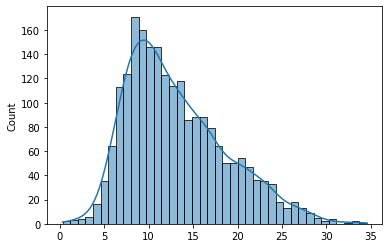

In [45]:
sns.histplot(y_pred,bins=40,kde=True)

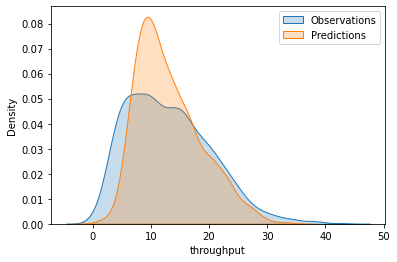

In [46]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

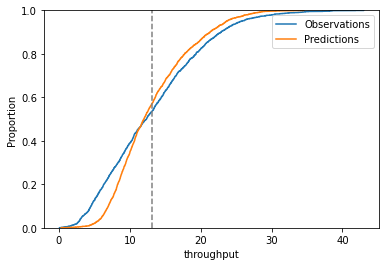

In [47]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [48]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [49]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,poi-wo
MAE,3.216113
MSE,17.816642
RMSE,4.220976


In [50]:
err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [51]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}.joblib')

['./opt-models/poi-wo.joblib']

In [52]:
res = y - y_pred
res.describe().drop('count')

mean    -0.000052
std      4.221963
min    -17.806513
25%     -2.817329
50%     -0.498959
75%      2.294527
max     32.504122
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

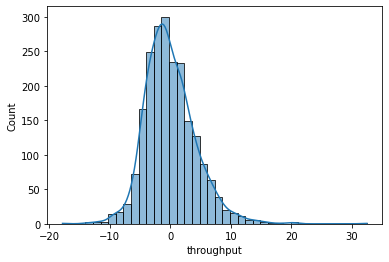

In [53]:
sns.histplot(data=res, kde=True,bins=40)

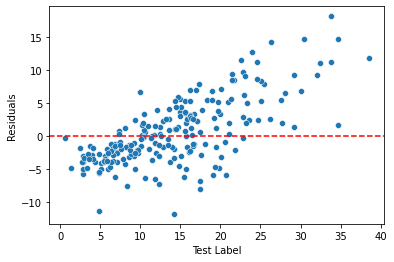

In [54]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

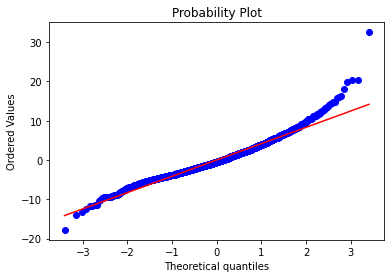

In [55]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!